In [1]:
%matplotlib inline
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

/home/evgeny/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
train = np.loadtxt('../002/data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('../002/data/digit/test.csv', delimiter=',', skiprows=1)

In [4]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

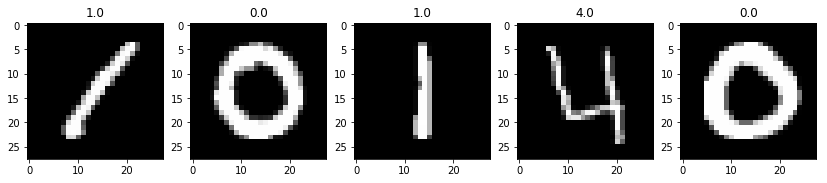

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [7]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

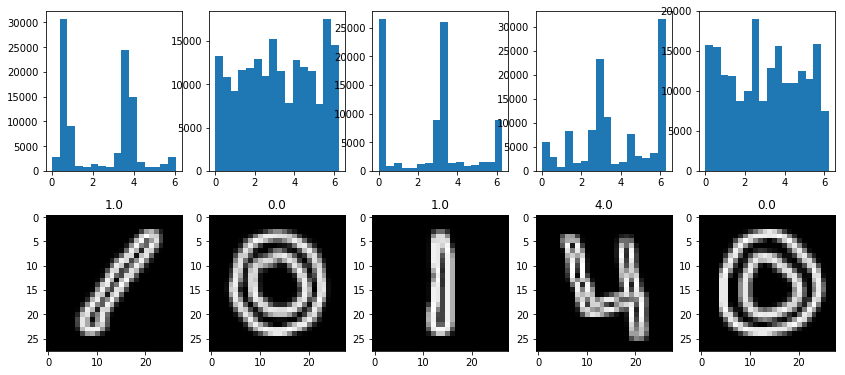

In [8]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [12]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist
    
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [13]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [14]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)

## Собираем полносвязную сеть для обучения

In [15]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(32,
                             input_dim=x_train.shape[1],
                             activation='relu'))

model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Выводим информацию о модели

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 874
Trainable params: 874
Non-trainable params: 0
_________________________________________________________________


## One hot encoding разметки

In [17]:
y_train.shape

(33600,)

In [18]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)

## Запускаем обучение

In [19]:
model.fit(x_train, y_train_labels, 
          batch_size=32, validation_split=0.2,
          epochs=10)

Train on 26880 samples, validate on 6720 samples
Epoch 1/10
26880/26880 [==============================] - 2s 88us/step - loss: 1.8096 - acc: 0.3618 - val_loss: 1.5172 - val_acc: 0.4543
Epoch 2/10
26880/26880 [==============================] - 2s 74us/step - loss: 1.4183 - acc: 0.4982 - val_loss: 1.3565 - val_acc: 0.5199
Epoch 3/10
26880/26880 [==============================] - 2s 77us/step - loss: 1.3104 - acc: 0.5362 - val_loss: 1.2792 - val_acc: 0.5507
Epoch 4/10
26880/26880 [==============================] - 2s 72us/step - loss: 1.2480 - acc: 0.5635 - val_loss: 1.2347 - val_acc: 0.5625
Epoch 5/10
26880/26880 [==============================] - 2s 77us/step - loss: 1.2078 - acc: 0.5764 - val_loss: 1.1952 - val_acc: 0.5848
Epoch 6/10
26880/26880 [==============================] - 2s 76us/step - loss: 1.1812 - acc: 0.5855 - val_loss: 1.1751 - val_acc: 0.5839
Epoch 7/10
26880/26880 [==============================] - 2s 77us/step - loss: 1.1625 - acc: 0.5902 - val_loss: 1.1589 - val_acc:

## Предсказываем класс объекта

In [30]:
from sklearn.linear_model import LogisticRegression

In [20]:
pred_val = model.predict_classes(x_val)

In [21]:
pred_proba = model.predict_proba(x_val)

## Оцениваем качество решение на валидационной выборке

In [22]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.5935714285714285


In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.39      0.26      0.31       816
        1.0       0.92      0.96      0.94       909
        2.0       0.43      0.33      0.37       846
        3.0       0.61      0.72      0.66       937
        4.0       0.69      0.57      0.62       839
        5.0       0.53      0.62      0.57       702
        6.0       0.41      0.43      0.42       785
        7.0       0.78      0.78      0.78       893
        8.0       0.47      0.57      0.51       835
        9.0       0.58      0.63      0.60       838

avg / total       0.59      0.59      0.59      8400



In [24]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[214  14  73  30  27  30 182   6 193  47]
 [  4 874   2   0  20   0   0   4   1   4]
 [ 32   0 276 170   4 169  40  32  99  24]
 [ 21   0  64 673   0  91   4   4  69  11]
 [ 22  42  11   3 480   0 112  54   9 106]
 [  3   0  64 131   0 434   8  10  47   5]
 [111   3  59  14  66  14 334  18  91  75]
 [ 10   8  29   6  28  15  35 699   4  59]
 [103   0  30  63   7  54  44   6 475  53]
 [ 33   6  34  12  67   8  55  63  33 527]]


## Предсказания на тестовыйх данных

In [ ]:
pred_test = model.predict_classes(test_hist)

## Визуализируем предсказания

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [75]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
# Your submission scored 0.59843